In [1]:
import os
import jax
import pickle

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=24'
jax.config.update('jax_platform_name', 'cpu')

#from jax.config import config; config.update("jax_enable_x64", True)

%load_ext autoreload
%autoreload 2

from brax import envs
from brax.io import html, model
from brax.training import normalization

import flax
import jax.numpy as jnp
from brax.envs import create_fn

from IPython.display import HTML, clear_output

import optax

import matplotlib.pyplot as plt
import numpy as np

from controllers import GruController, MlpController, LinearController

from ce_apg import do_one_rollout, cem_apg

from functools import partial

def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, qps, height=height))

len(jax.devices())

save_dir = "save_ce_apg4"

0.018970074


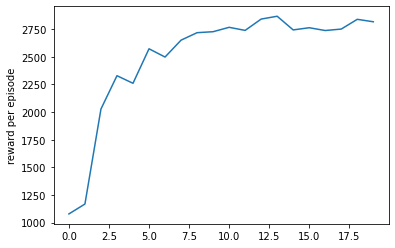

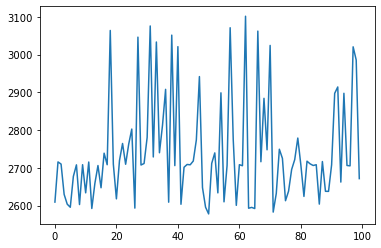

 Iteration 19 --------------------------------
0 : reward: 2615.647705078125 -> 2817.71484375
1 : reward: 2696.40087890625 -> 2780.356201171875
2 : reward: 2713.35302734375 -> 2745.658935546875
3 : reward: 2592.89990234375 -> 2696.763427734375
4 : reward: 2684.609130859375 -> 2650.783203125
5 : reward: 1810.462646484375 -> 2634.091064453125
6 : reward: 2559.273193359375 -> 2627.194091796875
7 : reward: 2463.20263671875 -> 2551.004638671875
---
8 : reward: 2434.078369140625 -> 2475.590576171875
9 : reward: 2606.44677734375 -> 2440.5537109375
10 : reward: 2384.972412109375 -> 2416.200927734375
11 : reward: 2346.666748046875 -> 2393.323486328125
12 : reward: 2434.32861328125 -> 2383.77880859375
13 : reward: 2372.3828125 -> 2383.544677734375
14 : reward: 2165.432861328125 -> 2322.404541015625
15 : reward: 2250.87451171875 -> 2287.62158203125
16 : reward: 2210.434814453125 -> 2225.45263671875
17 : reward: 2185.438720703125 -> 2140.1484375
18 : reward: 2005.3367919921875 -> 2023.310424804687

In [5]:
#for env_name in ["inverted_pendulum_swingup" , "acrobot", "inverted_double_pendulum_swingup"]:  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]
for env_name in ["acrobot"]: #, "acrobot", "inverted_double_pendulum_swingup"]:  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

     
    episode_length = 500
    action_repeat = 1
    env_fn = create_fn(env_name = env_name, episode_length=episode_length, action_repeat=action_repeat, batch_size=None, auto_reset=False)
    env = env_fn()

    policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
    print(policy_size)
    policy = GruController(env.observation_size, env.action_size, policy_size)
    pickle.dump(policy, open(f"{save_dir}/{env_name}_policy", 'wb'))
    
    for i in range(1):
        inference_fn, params, rewards = cem_apg(env_fn,
                                                20,
                                                key=jax.random.PRNGKey(i),
                                                episode_length = episode_length,
                                                action_repeat = action_repeat,
                                                apg_epochs = 100,
                                                batch_size = 1,
                                                zero_params=False,
                                                truncation_length = None,
                                                learning_rate = 1e-4,
                                                clipping = 1e9,
                                                initial_std = 0.01,
                                                num_elite = 8,
                                                eps = 0.0,
                                                normalize_observations=True,
                                                policy = policy,
                                                learning_schedule = [-3, -6]
                                               )

        model.save_params(f"{save_dir}/{env_name}_params_{i}", params)
        pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", "wb"))



In [4]:
from brax.io import model
import ce_apg

env_name = 'acrobot'
episode_length = 500
action_repeat = 1
env_fn = create_fn(env_name = env_name, episode_length=episode_length, action_repeat=action_repeat, batch_size=None, auto_reset=False)
env = env_fn()

# model.save_params('/tmp/params', params)
# inference_fn = ce_apg.make_inference_fn(
#     env.observation_size, env.action_size, True, policy)
# params = model.load_params('/tmp/params')

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
#jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)
h = np.zeros_like(state.obs)

r = []
while not state.done:
  rollout.append(state)
  r.append(state.reward)
  #h, act = jit_inference_fn(params, h, state.obs)
  act = jnp.ones(1)
  state = jit_env_step(state, act)

print(sum(r))
HTML(html.render(env.sys, [s.qp for s in rollout]))

-319.9921


In [ ]:
# env_name = "acrobot"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

# episode_length = 500
# action_repeat = 1
# env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
# env = env_fn()



# policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
# print(policy_size)
# policy = GruController(env.observation_size, env.action_size, 32)

# for i in range(8):
#     normalizer_params, policy_params, rewards = cem_apg(env_fn,
#                                                         200,
#                                                         key=jax.random.PRNGKey(i),
#                                                         episode_length = episode_length,
#                                                         action_repeat = action_repeat,
#                                                         apg_epochs = 75,
#                                                         cem_epochs = 1,
#                                                         batch_size = 1,
#                                                         truncation_length = None,
#                                                         learning_rate = 5e-4,
#                                                         clipping = 1e9,
#                                                         initial_std = 0.01,
#                                                         num_elite = 8,
#                                                         eps = 0.0,
#                                                         normalize_observations=True,
#                                                         policy = policy
#                                                        )



#     pickle.dump(policy_params, open(f"{save_dir}/{env_name}_policy{i}.pkl", 'wb'))
#     pickle.dump(normalizer_params, open(f"{save_dir}/{env_name}_normalize{i}.pkl", 'wb'))
#     pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [ ]:
# env_name = "inverted_double_pendulum_swingup"  # @param ['ant', 'humanoid', 'fetch', 'grasp', 'halfcheetah', 'walker2d, 'ur5e', 'reacher', bball_1dof]

# episode_length = 500
# action_repeat = 1
# env_fn = create_fn(env_name = env_name, action_repeat=action_repeat, batch_size=None, auto_reset=False)
# env = env_fn()



# policy_size = int(2**jnp.ceil(jnp.log2(env.observation_size*4)))
# print(policy_size)
# policy = GruController(env.observation_size, env.action_size, 128)

# for i in range(8):
#     normalizer_params, policy_params, rewards = cem_apg(env_fn,
#                                                         200,
#                                                         key=jax.random.PRNGKey(i),
#                                                         episode_length = episode_length,
#                                                         action_repeat = action_repeat,
#                                                         apg_epochs = 75,
#                                                         cem_epochs = 1,
#                                                         batch_size = 1,
#                                                         truncation_length = None,
#                                                         learning_rate = 5e-4,
#                                                         clipping = 1e9,
#                                                         initial_std = 0.01,
#                                                         num_elite = 8,
#                                                         eps = 0.0,
#                                                         normalize_observations=True,
#                                                         policy = policy
#                                                        )



#     pickle.dump(policy_params, open(f"{save_dir}/{env_name}_policy{i}.pkl", 'wb'))
#     pickle.dump(normalizer_params, open(f"{save_dir}/{env_name}_normalize{i}.pkl", 'wb'))
#     pickle.dump(rewards, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [ ]:
# import pickle
# pickle.dump(policy_params2, open("inverted_double_pendulum_swingup.pickle", 'wb'))

In [ ]:
# env_name = "inverted_double_pendulum_swingup"
# pickle.dump(policy_params2, open(f"{env_name}_policy.pkl", 'wb'))
# pickle.dump(normalizer_params2, open(f"{env_name}_normalize.pkl", 'wb'))
# pickle.dump(rewards2, open(f"{env_name}_rewards.pkl", 'wb'))